# Grass growth anomalies

- Weighted means take into account the number of days in each month

In [1]:
import glob
import importlib
import itertools
import os
import sys
from datetime import datetime, timezone
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import climag.climag as cplt
from climag import climag_plot

In [ ]:
exp_list = ["historical", "rcp45", "rcp85"]
model_list = ["CNRM-CM5", "EC-EARTH", "HadGEM2-ES", "MPI-ESM-LR"]
dataset_list = ["EURO-CORDEX", "HiResIreland"]

In [4]:
def keep_minimal_vars(data):
    """
    Drop variables that are not needed
    """

    data = data.drop_vars(
        [
            "bm_gv",
            "bm_gr",
            "bm_dv",
            "bm_dr",
            "age_gv",
            "age_gr",
            "age_dv",
            "age_dr",
            "omd_gv",
            "omd_gr",
            "lai",
            "env",
            "wr",
            "aet",
            "sen_gv",
            "sen_gr",
            "abs_dv",
            "abs_dr",
            "c_bm",
            "bm",
            "pgro",
            "i_bm",
            "h_bm",
        ]
    )

    return data

In [5]:
def combine_datasets(dataset_dict, dataset_crs):
    dataset = xr.combine_by_coords(
        dataset_dict.values(), combine_attrs="override"
    )
    dataset.rio.write_crs(dataset_crs, inplace=True)

    return dataset

In [6]:
def generate_stats(dataset):
    ds = {}

    for exp, model in itertools.product(exp_list, model_list):
        # auto-rechunking may cause NotImplementedError with object dtype
        # where it will not be able to estimate the size in bytes of object
        # data
        if model == "HadGEM2-ES":
            CHUNKS = 300
        else:
            CHUNKS = "auto"

        ds[f"{model}_{exp}"] = xr.open_mfdataset(
            glob.glob(
                os.path.join(
                    "data",
                    "ModVege",
                    dataset,
                    exp,
                    model,
                    f"*{dataset}*{model}*{exp}*.nc",
                )
            ),
            chunks=CHUNKS,
            decode_coords="all",
        )

        # copy CRS
        crs_ds = ds[f"{model}_{exp}"].rio.crs

        # remove spin-up year
        if exp == "historical":
            ds[f"{model}_{exp}"] = ds[f"{model}_{exp}"].sel(
                time=slice("1976", "2005")
            )
        else:
            ds[f"{model}_{exp}"] = ds[f"{model}_{exp}"].sel(
                time=slice("2041", "2070")
            )

        # convert HadGEM2-ES data back to 360-day calendar
        # this ensures that the correct weighting is applied when
        # calculating the weighted average
        if model == "HadGEM2-ES":
            ds[f"{model}_{exp}"] = ds[f"{model}_{exp}"].convert_calendar(
                "360_day", align_on="year"
            )

        # assign new coordinates and dimensions
        ds[f"{model}_{exp}"] = ds[f"{model}_{exp}"].assign_coords(exp=exp)
        ds[f"{model}_{exp}"] = ds[f"{model}_{exp}"].expand_dims(dim="exp")
        ds[f"{model}_{exp}"] = ds[f"{model}_{exp}"].assign_coords(model=model)
        ds[f"{model}_{exp}"] = ds[f"{model}_{exp}"].expand_dims(dim="model")

        # drop unnecessary variables
        ds[f"{model}_{exp}"] = keep_minimal_vars(data=ds[f"{model}_{exp}"])

        # weighted mean
        weights = (
            ds[f"{model}_{exp}"]["time"].dt.days_in_month.groupby("time.year")
            / ds[f"{model}_{exp}"]["time"]
            .dt.days_in_month.groupby("time.year")
            .sum()
        )

        # test that the sum of weights for each season is one
        np.testing.assert_allclose(
            weights.groupby("time.year").sum().values,
            np.ones(len(set(weights["year"].values))),
        )

        # calculate the weighted average
        ds[f"{model}_{exp}"] = (
            (ds[f"{model}_{exp}"] * weights)
            .groupby("time.year")
            .sum(dim="time")
        )

    # combine data
    ds = combine_datasets(ds, crs_ds)

    # ensemble mean
    ds = ds.mean(dim="model", skipna=True)

    # long-term average
    ds_lta = ds.mean(dim="year", skipna=True)

    return ds, ds_lta

In [7]:
# mask out non-pasture areas
mask_layer = gpd.read_file(
    os.path.join("data", "boundaries", "boundaries_all.gpkg"),
    layer="CLC_2018_MASK_PASTURE_2157_IE",
)
# mask for offshore areas
ie_bbox = gpd.read_file(
    os.path.join("data", "boundaries", "boundaries_all.gpkg"),
    layer="ne_10m_land_2157_IE_BBOX_DIFF",
)

In [8]:
def plot_diff(data, levels, mask=True):
    for exp in list(data["exp"].values):
        print(exp)
        if exp == "historical":
            data_plot = data.sel(year=slice("1976", "2005"))
        else:
            data_plot = data.sel(year=slice("2041", "2070"))
        fig = data_plot.sel(exp=exp)["gro"].plot.contourf(
            x="rlon",
            y="rlat",
            col="year",
            col_wrap=6,
            subplot_kws={"projection": cplt.projection_hiresireland},
            transform=cplt.rotated_pole_transform(data),
            xlim=(-1.775, 1.6),
            ylim=(-2.1, 2.1),
            figsize=(12, 15.25),
            extend="both",
            robust=True,
            cmap="BrBG",
            levels=colorbar_levels(levels),
            cbar_kwargs={
                "label": "Anomaly [kg DM ha⁻¹ day⁻¹]",
                "aspect": 40,
                "location": "bottom",
                "fraction": 0.085,
                "shrink": 0.85,
                "pad": 0.025,
                "extendfrac": "auto",
                "ticks": climag_plot.colorbar_ticks(levels),
            },
        )
        for axis in fig.axs.flat:
            if mask:
                mask_layer.to_crs(cplt.projection_hiresireland).plot(
                    ax=axis, color="white", linewidth=0
                )
            ie_bbox.to_crs(cplt.projection_hiresireland).plot(
                ax=axis,
                edgecolor="darkslategrey",
                color="white",
                linewidth=0.5,
            )
        fig.set_titles("{value}", weight="semibold", fontsize=14)
        plt.show()

## Anomalies per year

In [9]:
eurocordex, eurocordex_lta = generate_stats("EURO-CORDEX")

In [10]:
eurocordex_diff = eurocordex - eurocordex_lta

In [11]:
hiresireland, hiresireland_lta = generate_stats("HiResIreland")

In [12]:
hiresireland_diff = hiresireland - hiresireland_lta

### EURO-CORDEX

In [13]:
# plot_diff(eurocordex_diff, 8)

#### Compared to historical (1976-2005) LTA

In [14]:
# plot_diff(
#     (
#         eurocordex.sel(exp=["rcp45", "rcp85"]) -
#         eurocordex_lta.sel(exp="historical").drop_vars("exp")
#     ),
#     8
# )

### HiResIreland

In [15]:
# plot_diff(hiresireland_diff, 8)

#### Compared to historical (1976-2005) LTA

In [16]:
# plot_diff(
#     (
#         hiresireland.sel(exp=["rcp45", "rcp85"]) -
#         hiresireland_lta.sel(exp="historical").drop_vars("exp")
#     ),
#     8
# )

## Mean

### EURO-CORDEX

In [17]:
plot_data = (
    (
        eurocordex.mean(dim="year", skipna=True)
        - eurocordex_lta.sel(exp="historical").drop_vars("exp")
    )
    .sel(exp=["rcp45", "rcp85"])
    .assign_coords(dataset="EURO-CORDEX")
    .expand_dims(dim="dataset")
)

In [18]:
# plot_data["exp"] = plot_data["exp"].where(
#     plot_data["exp"] != "rcp45", "rcp45 - historical"
# )

# plot_data["exp"] = plot_data["exp"].where(
#     plot_data["exp"] != "rcp85", "rcp85 - historical"
# )

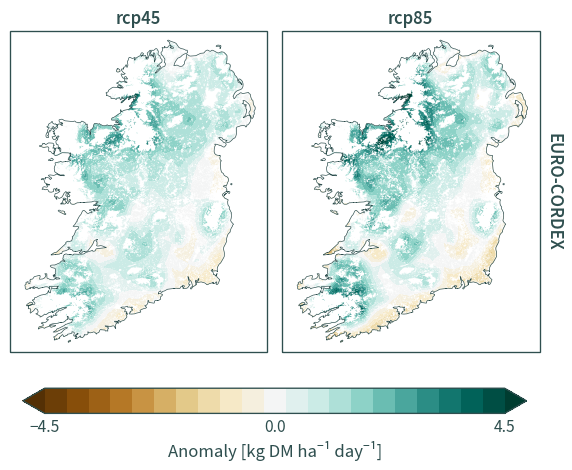

In [19]:
fig = plot_data["gro"].plot.contourf(
    x="rlon",
    y="rlat",
    col="exp",
    row="dataset",
    robust=True,
    extend="both",
    cmap="BrBG",
    subplot_kws={"projection": cplt.projection_hiresireland},
    transform=cplt.rotated_pole_transform(plot_data),
    xlim=(-1.775, 1.6),
    ylim=(-2.1, 2.1),
    figsize=(6, 4.75),
    levels=climag_plot.colorbar_levels(4.5),
    cbar_kwargs={
        "label": "Anomaly [kg DM ha⁻¹ day⁻¹]",
        "aspect": 20,
        "location": "bottom",
        "fraction": 0.085,
        "shrink": 0.95,
        "pad": 0.085,
        "extendfrac": "auto",
        "ticks": climag_plot.colorbar_ticks(4.5),
    },
)
for axis in fig.axs.flat:
    mask_layer.to_crs(cplt.projection_hiresireland).plot(
        ax=axis, color="white", linewidth=0
    )
    ie_bbox.to_crs(cplt.projection_hiresireland).plot(
        ax=axis, edgecolor="darkslategrey", color="white", linewidth=0.5
    )
fig.set_titles("{value}", weight="semibold", fontsize=14)
plt.show()

### HiResIreland

In [20]:
plot_data = (
    (
        hiresireland.mean(dim="year", skipna=True)
        - hiresireland_lta.sel(exp="historical").drop_vars("exp")
    )
    .sel(exp=["rcp45", "rcp85"])
    .assign_coords(dataset="HiResIreland")
    .expand_dims(dim="dataset")
)

In [21]:
# plot_data["exp"] = plot_data["exp"].where(
#     plot_data["exp"] != "rcp45", "rcp45 - historical"
# )

# plot_data["exp"] = plot_data["exp"].where(
#     plot_data["exp"] != "rcp85", "rcp85 - historical"
# )

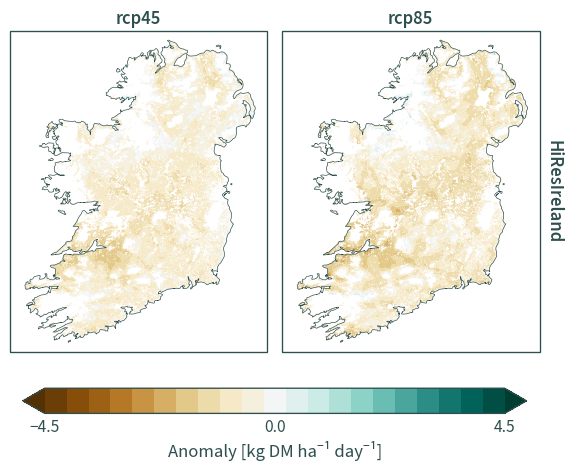

In [22]:
fig = plot_data["gro"].plot.contourf(
    x="rlon",
    y="rlat",
    col="exp",
    row="dataset",
    robust=True,
    extend="both",
    cmap="BrBG",
    subplot_kws={"projection": cplt.projection_hiresireland},
    transform=cplt.rotated_pole_transform(plot_data),
    xlim=(-1.775, 1.6),
    ylim=(-2.1, 2.1),
    figsize=(6, 4.75),
    levels=climag_plot.colorbar_levels(4.5),
    cbar_kwargs={
        "label": "Anomaly [kg DM ha⁻¹ day⁻¹]",
        "aspect": 20,
        "location": "bottom",
        "fraction": 0.085,
        "shrink": 0.95,
        "pad": 0.085,
        "extendfrac": "auto",
        "ticks": climag_plot.colorbar_ticks(4.5),
    },
)
for axis in fig.axs.flat:
    mask_layer.to_crs(cplt.projection_hiresireland).plot(
        ax=axis, color="white", linewidth=0
    )
    ie_bbox.to_crs(cplt.projection_hiresireland).plot(
        ax=axis, edgecolor="darkslategrey", color="white", linewidth=0.5
    )
fig.set_titles("{value}", weight="semibold", fontsize=14)
plt.show()